In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import log_loss
sns.set_style("darkgrid")
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Bidirectional, Dropout, concatenate
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc, mean_squared_error,  mean_absolute_error, jaccard_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.stats import zscore
from scipy import stats

In [4]:
#Loading the dataset
dataset = pd.read_csv('WADI_59 SENSORS.csv')
dataset = dataset.dropna()

In [5]:
# extract the features and target variable
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [6]:
# preprocess the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
from imblearn.over_sampling import SMOTE
#smote = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [8]:
# split the dataset into training, testing, and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
dataset.head()

,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LT_001_PV,2_DPIT_001_PV,2_FIC_101_CO,2_FIC_101_PV,...,2B_AIT_003_PV,2B_AIT_004_PV,3_AIT_002_PV,3_AIT_003_PV,3_AIT_004_PV,3_AIT_005_PV,3_FIT_001_PV,3_LT_001_PV,LEAK_DIFF_PRESSURE,"Attack LABLE (1:No Attack, -1:Attack)"
0,164.21,0.529486,11.9972,482.48,0.331167,0.001273,48.482,2538.7,35.6659,0.240392,...,8.69146,475.488,8279.1,11.528,-65.9686,0.755703,0.626306,64.3306,62.6226,1
1,164.21,0.529486,11.9972,482.48,0.331167,0.001273,48.482,2538.7,35.6659,0.240392,...,8.69146,475.488,8279.1,11.528,-65.9686,0.755703,0.626306,64.3306,62.6226,1
2,164.21,0.529486,11.9972,482.48,0.331167,0.001273,48.482,2538.7,35.6659,0.240392,...,8.69146,475.488,8279.1,11.528,-65.9686,0.755703,0.626306,64.3306,62.6226,1
3,164.21,0.529486,11.9972,482.48,0.331167,0.001273,48.482,2538.7,35.6659,0.240392,...,8.72859,475.394,8279.1,11.528,-65.9686,0.755703,0.626306,64.3306,62.6226,1
4,164.21,0.529486,11.9972,482.48,0.331167,0.001273,48.482,2538.7,35.6659,0.240392,...,8.72859,475.394,8279.1,11.528,-65.9686,0.755703,0.626306,64.3306,62.6226,1


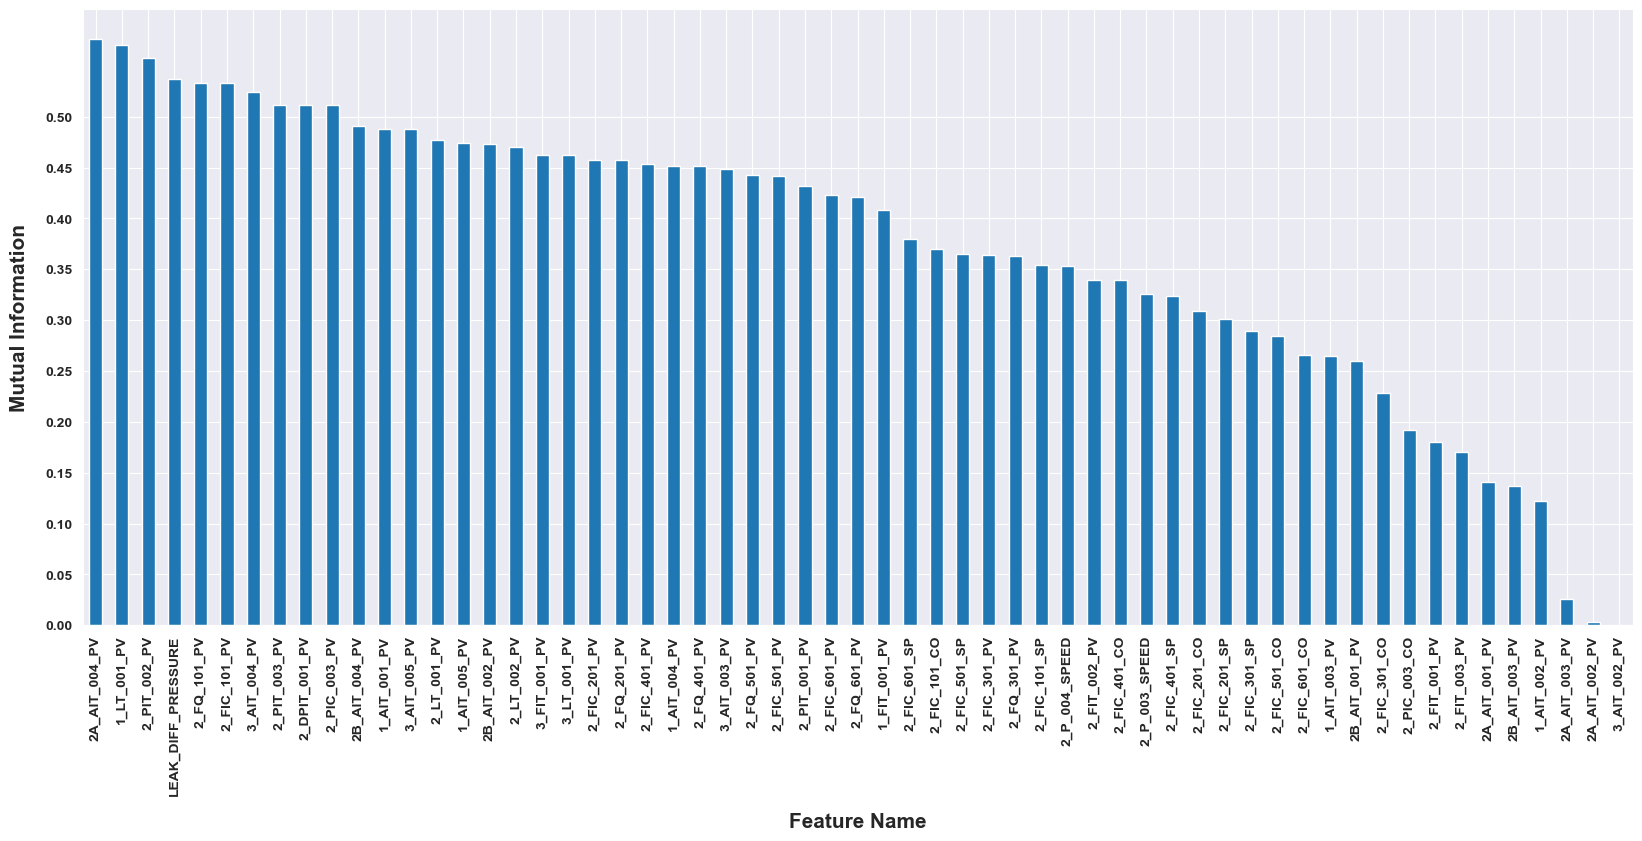

Best Threshold: 0.2353622839699922
Best Cross-Validation Score: 0.9998224683256826


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import SparsePCA
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Assuming X_train, y_train, X_val, X_test, and dataset are already defined

# Convert X_train to DataFrame for feature names
X_train_df = pd.DataFrame(X_train, columns=dataset.columns[:-1])

# Calculate Mutual Information
mutual_info = mutual_info_classif(X_train_df, y_train)
mutual_info = pd.Series(mutual_info, index=X_train_df.columns)

# Sort by Mutual Information
mutual_info_sorted = mutual_info.sort_values(ascending=False)

# Plot the ordered mutual_info values per feature
plt.figure(figsize=(20, 8))
mutual_info_sorted.plot.bar()
plt.xticks(weight="bold", rotation=90)
plt.yticks(np.arange(0, 0.55, 0.05), weight="bold")  # Set y-axis ticks
plt.xlabel("Feature Name", weight="bold", labelpad=12, fontsize=15)
plt.ylabel("Mutual Information", weight="bold", labelpad=12, fontsize=15)
plt.show()

# Initialize variables for cross-validation
best_threshold = 0
best_score = 0

# Perform cross-validation for different thresholds
thresholds = np.linspace(mutual_info_sorted.min(), mutual_info_sorted.max(), 50)
for threshold in thresholds:
    selected_features = mutual_info_sorted[mutual_info_sorted >= threshold].index
    X_selected = X_train_df[selected_features]

    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize the model
    model = DecisionTreeClassifier(random_state=42)
    
    # Evaluate the model using cross-validation
    scores = cross_val_score(model, X_selected, y_train, cv=cv, scoring='accuracy')
    mean_score = np.mean(scores)
    
    # Update the best threshold and score
    if mean_score > best_score:
        best_score = mean_score
        best_threshold = threshold

print(f'Best Threshold: {best_threshold}')
print(f'Best Cross-Validation Score: {best_score}')

# Select features based on the best threshold
final_selected_features = mutual_info_sorted[mutual_info_sorted >= best_threshold].index
X_train_selected = X_train_df[final_selected_features]
X_test_selected = pd.DataFrame(X_test, columns=dataset.columns[:-1])[final_selected_features]
X_val_selected = pd.DataFrame(X_val, columns=dataset.columns[:-1])[final_selected_features]

# Apply SparsePCA for feature reduction
spca = SparsePCA(n_components=14)
X_train = spca.fit_transform(X_train_selected)
X_val = spca.transform(X_val_selected)
X_test = spca.transform(X_test_selected)

# Reshape the data for the LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import Layer

# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_sum = tf.reduce_sum(inputs * attention_weights, axis=1)
        return weighted_sum

model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
# Add attention mechanism after the second LSTM layer
model.add(AttentionLayer())

# Reshape the output of the Attention layer to add the missing timestep dimension
model.add(tf.keras.layers.Reshape((1, -1)))

model.add(LSTM(units=32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])



In [12]:
#Define a learning rate schedular
def scheduler(epoch, lr):
    if epoch <=10:
        return lr #Keep the initial learning rate for the first 200 epochs
    else:
        return lr * tf.math.exp(-0.1) # Reduce the learning rate by a factor of 0.1 after the 200th epoch

In [13]:
lr=0.001
for i in range (100):
    lr=scheduler(i,lr)
    print(i,lr)


0 0.001
1 0.001
2 0.001
3 0.001
4 0.001
5 0.001
6 0.001
7 0.001
8 0.001
9 0.001
10 0.001
11 tf.Tensor(0.00090483745, shape=(), dtype=float32)
12 tf.Tensor(0.0008187308, shape=(), dtype=float32)
13 tf.Tensor(0.0007408183, shape=(), dtype=float32)
14 tf.Tensor(0.0006703201, shape=(), dtype=float32)
15 tf.Tensor(0.00060653075, shape=(), dtype=float32)
16 tf.Tensor(0.00054881175, shape=(), dtype=float32)
17 tf.Tensor(0.0004965854, shape=(), dtype=float32)
18 tf.Tensor(0.00044932903, shape=(), dtype=float32)
19 tf.Tensor(0.0004065697, shape=(), dtype=float32)
20 tf.Tensor(0.0003678795, shape=(), dtype=float32)
21 tf.Tensor(0.00033287113, shape=(), dtype=float32)
22 tf.Tensor(0.00030119426, shape=(), dtype=float32)
23 tf.Tensor(0.00027253185, shape=(), dtype=float32)
24 tf.Tensor(0.00024659702, shape=(), dtype=float32)
25 tf.Tensor(0.0002231302, shape=(), dtype=float32)
26 tf.Tensor(0.00020189656, shape=(), dtype=float32)
27 tf.Tensor(0.00018268357, shape=(), dtype=float32)
28 tf.Tensor(0.00

In [14]:
callback=LearningRateScheduler(scheduler)

In [15]:
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, 
                    validation_data=(X_val.reshape((X_val.shape[0], X_val.shape[1], 1)), y_val),
                    epochs=100, batch_size=64, verbose=1, callbacks=callback)

Epoch 1/100


3257/3257 [==============================] - 95s 25ms/step - loss: 0.0667 - accuracy: 0.9136 - val_loss: 0.0301 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 2/100
3257/3257 [==============================] - 79s 24ms/step - loss: 0.0280 - accuracy: 0.9686 - val_loss: 0.0218 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 3/100
3257/3257 [==============================] - 82s 25ms/step - loss: 0.0217 - accuracy: 0.9762 - val_loss: 0.0181 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 4/100
3257/3257 [==============================] - 82s 25ms/step - loss: 0.0205 - accuracy: 0.9780 - val_loss: 0.0182 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 5/100
3257/3257 [==============================] - 81s 25ms/step - loss: 0.0185 - accuracy: 0.9803 - val_loss: 0.0151 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 6/100
3257/3257 [==============================] - 85s 26ms/step - loss: 0.0182 - accuracy: 0.9804 - val_loss: 0.0149 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 7/100
3257/3257 [===============

In [16]:
_,acc = model.evaluate(X_test, y_test)
print("Accuracy =", (acc * 100.0), "%")
_,pre = model.evaluate(X_test, y_test)
print("Precision =", (pre * 100.0), "%")
_,f1score = model.evaluate(X_test, y_test)
print("F1 Score =", (f1score * 100.0), "%")
_,rec = model.evaluate(X_test, y_test)
print("Recall =", (rec * 100.0), "%")
_,score = model.evaluate(X_test, y_test)
print('Test score:', (score * 100.0), "%")

2036/2036 [==============================] - 8s 4ms/step - loss: 0.0126 - accuracy: 0.9873
Accuracy = 98.7317681312561 %
2036/2036 [==============================] - 8s 4ms/step - loss: 0.0126 - accuracy: 0.9873
Precision = 98.7317681312561 %
2036/2036 [==============================] - 8s 4ms/step - loss: 0.0126 - accuracy: 0.9873
F1 Score = 98.7317681312561 %
2036/2036 [==============================] - 8s 4ms/step - loss: 0.0126 - accuracy: 0.9873
Recall = 98.7317681312561 %
2036/2036 [==============================] - 8s 4ms/step - loss: 0.0126 - accuracy: 0.9873
Test score: 98.7317681312561 %


2036/2036 [==============================] - 9s 4ms/step
Precision: 0.9873
Recall: 0.9873
Accuracy: 0.9873
F1 Score: 0.9875
Jaccard Score: 0.9753
Log Loss: 0.4571
Confusion Matrix:
[[31679   743]
 [   83 32625]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     32422
           1       0.98      1.00      0.99     32708

    accuracy                           0.99     65130
   macro avg       0.99      0.99      0.99     65130
weighted avg       0.99      0.99      0.99     65130

ROC AUC Score:
0.9872729281840561


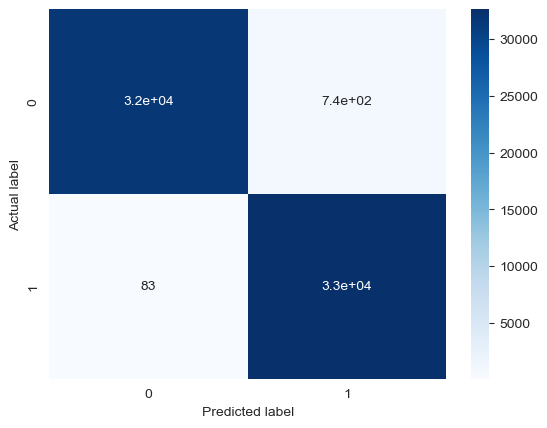

In [17]:
# Evaluate the model
#y_pred = model.predict(X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1)))
#y_pred = model.predict_classes(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#print("Confusion Matrix:")
print('Precision: %.4f' % precision_score(y_test, y_pred, average='micro'))
print('Recall: %.4f' % recall_score(y_test, y_pred, average='micro'))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.4f' % f1_score(y_test, y_pred))
print('Jaccard Score: %.4f' % jaccard_score(y_test, y_pred))
print('Log Loss: %.4f' % log_loss(y_test, y_pred))
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred))

2036/2036 [==============================] - 8s 4ms/step


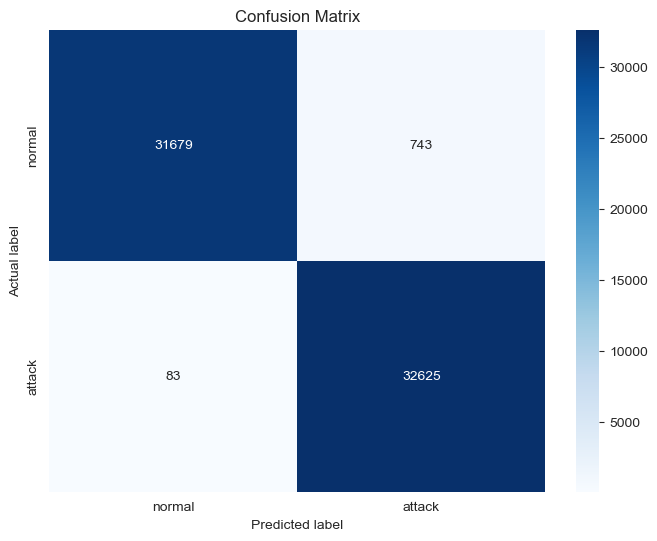

Precision: 0.9873
Recall: 0.9873
Accuracy: 0.9873
F1 Score: 0.9875
Jaccard Score: 0.9753
Log Loss: 0.4571

Confusion Matrix:
[[31679   743]
 [   83 32625]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     32422
           1       0.98      1.00      0.99     32708

    accuracy                           0.99     65130
   macro avg       0.99      0.99      0.99     65130
weighted avg       0.99      0.99      0.99     65130


ROC AUC Score:
0.9872729281840561


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, jaccard_score, log_loss, classification_report, roc_auc_score

# Example: Assuming y_test and y_pred are defined
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['normal', 'attack']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Print evaluation metrics
print('Precision: %.4f' % precision_score(y_test, y_pred, average='micro'))
print('Recall: %.4f' % recall_score(y_test, y_pred, average='micro'))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.4f' % f1_score(y_test, y_pred))
print('Jaccard Score: %.4f' % jaccard_score(y_test, y_pred))
print('Log Loss: %.4f' % log_loss(y_test, y_pred))

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred))

In [19]:
# Calculate Z-score
training_error = history.history['loss'][-1]
testing_error = history.history['loss'][-1]
validation_error = history.history['val_loss'][-1]
z_score = (training_error - validation_error) / np.std(history.history['val_loss'])
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Training Error:", training_error)
print("Validation Error:", validation_error)
print("Z-Score:", z_score)


Mean Squared Error: 0.012682327652387533
Training Error: 0.012213869951665401
Validation Error: 0.011909738183021545
Z-Score: 0.10057469318647372


In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Compute predictions for the test dataset
y_test_pred = model.predict(X_test)
y_test_pred = (y_test_pred > 0.5)  # Convert predictions to binary

# Calculate Mean Squared Error for the test dataset
test_mse = mean_squared_error(y_test, y_test_pred)

# Calculate training and validation errors from history
training_error = history.history['loss'][-1]
validation_error = history.history['val_loss'][-1]

# Calculate the mean and standard deviation of training and validation errors
val_loss_std = np.std(history.history['val_loss'])
train_loss_mean = np.mean(history.history['loss'])

# Calculate Z-score for the test error
# Note: This is a relative measure, using training error and validation loss as benchmarks
z_score = (test_mse - train_loss_mean) / val_loss_std

# Print results
print("Test Mean Squared Error:", test_mse)
print("Training Error:", training_error)
print("Validation Error:", validation_error)
print("Z-Score (test error):", z_score)

2036/2036 [==============================] - 7s 3ms/step
Test Mean Squared Error: 0.012682327652387533
Training Error: 0.012213869951665401
Validation Error: 0.011909738183021545
Z-Score (test error): -0.4393552259925926


AUC: 0.9872729281840561


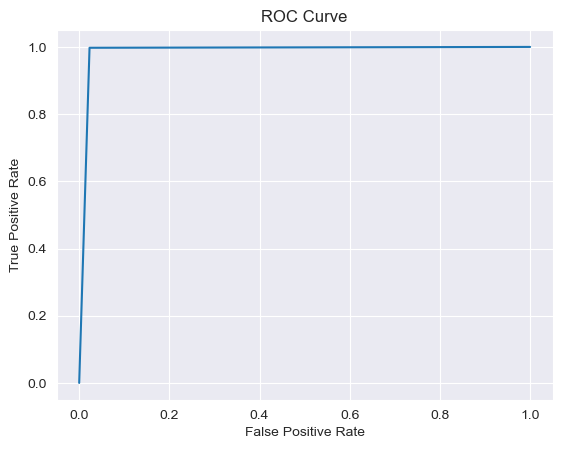

In [22]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plot.bar(figsize=(20,8))
print("AUC:", roc_auc)


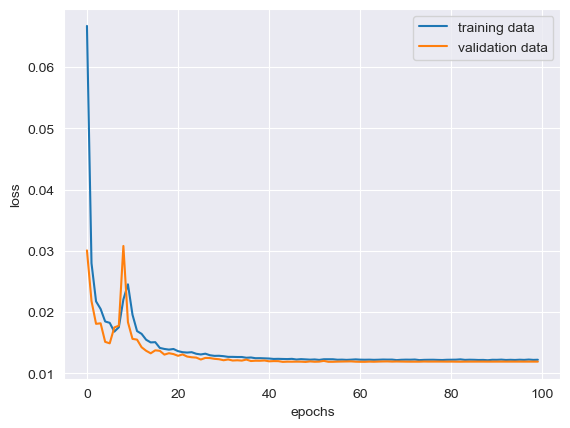

In [23]:
plt.plot(history.history['loss'], label="training data")
#plt.plot(history.history['loss'], label="testing data")
plt.plot(history.history['val_loss'], label="validation data" )
#plt.plot([training_error] * len(history.history['loss']), '--')
#plt.plot([validation_error] * len(history.history['loss']), '--')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.plot([mse])

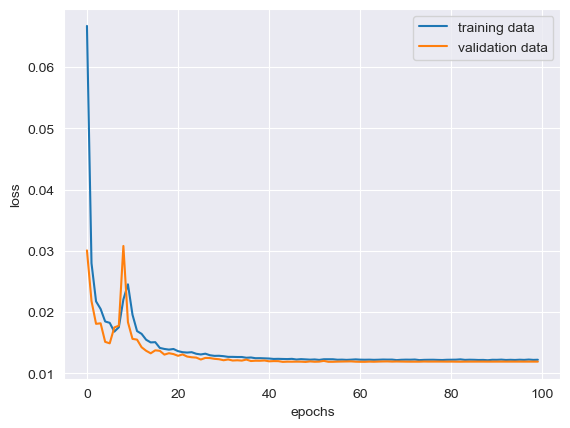

In [24]:
plt.plot(history.history['loss'], label="training data")
#plt.plot(history.history['loss'], label="testing data")
plt.plot(history.history['val_loss'], label="validation data" )
#plt.plot([training_error] * len(history.history['loss']), '--')
#plt.plot([validation_error] * len(history.history['loss']), '--')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.plot([mse])

In [25]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
#epochs=range(1, len(loss)+1)
plt.plot(epochs,acc,'y', label='training accuracy')
plt.plot(epochs,val_acc,'g', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

NameError: name 'epochs' is not defined

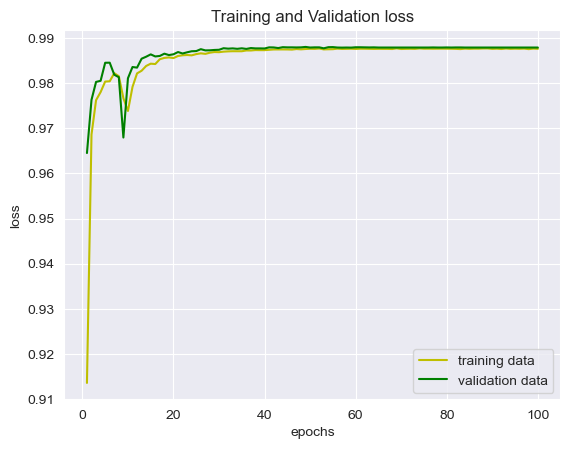

In [26]:
loss= history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(loss)+1)
plt.plot(epochs, acc,'y', label='training data')
plt.plot(epochs,val_acc,'g', label='validation data')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

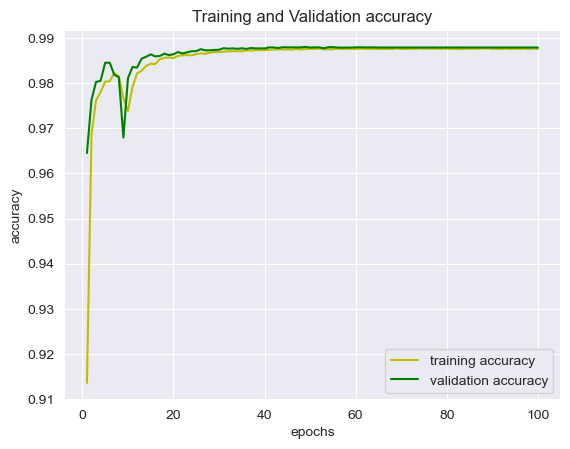

In [27]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
#epochs=range(1, len(loss)+1)
plt.plot(epochs,acc,'y', label='training accuracy')
plt.plot(epochs,val_acc,'g', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [28]:

# Predict probabilities for both models
pred = model.predict(X_test)


2036/2036 [==============================] - 8s 4ms/step


In [29]:
# Compute ROC curve and area under curve (AUC) for both models
fpr, tpr, thresholds = roc_curve(y_test, pred)
auc = auc(fpr, tpr)

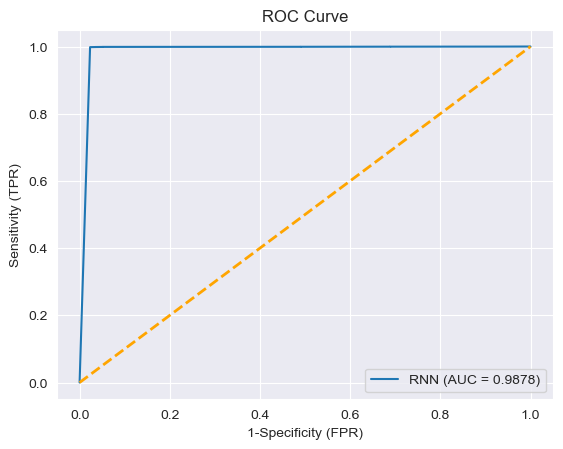

In [30]:
plt.plot(fpr, tpr, label='RNN (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], color='orange', lw=2, linestyle='--')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

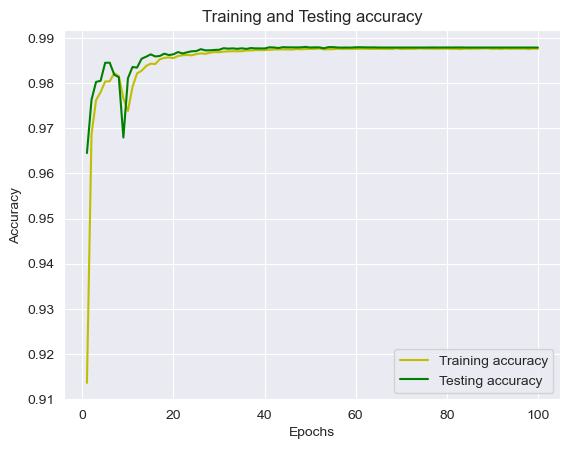

In [31]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']  # Training accuracy
test_acc = history.history['val_accuracy']  # Testing accuracy

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, test_acc, 'g', label='Testing accuracy')

plt.title('Training and Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


2036/2036 [==============================] - 10s 5ms/step - loss: 0.0126 - accuracy: 0.9873
Final Training Loss: 0.012213869951665401
Testing Loss: 0.01255466416478157


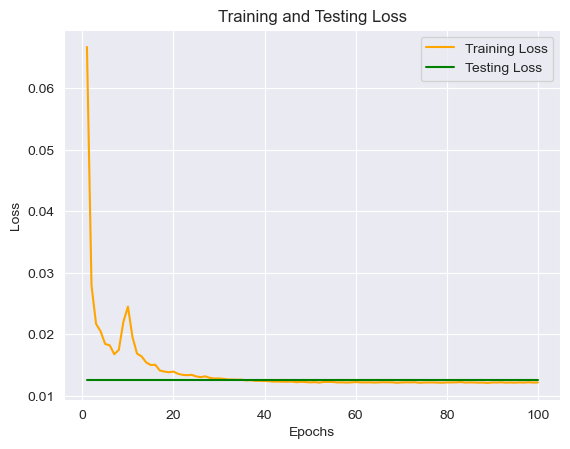

In [32]:
import matplotlib.pyplot as plt

# Extract training loss from history
train_loss = history.history['loss']

# Evaluate the model on the test data to get the testing loss
test_loss, _ = model.evaluate(X_test, y_test)

# Print training and testing loss
print(f"Final Training Loss: {train_loss[-1]}")
print(f"Testing Loss: {test_loss}")

# Create an array of epochs for plotting
epochs = range(1, len(train_loss) + 1)

# Plot training loss
plt.plot(epochs, train_loss, 'orange', label='Training Loss')

# Plot testing loss
plt.plot(epochs, [test_loss] * len(epochs), 'green', label='Testing Loss')

plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

2036/2036 [==============================] - 9s 4ms/step - loss: 0.0126 - accuracy: 0.9873
Final Training Accuracy: 0.9876015782356262
Testing Accuracy: [0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.987317681312561, 0.98731768

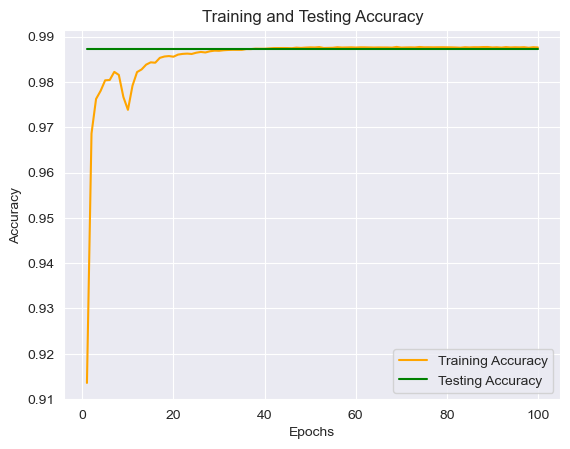

In [33]:
import matplotlib.pyplot as plt

# Example data (replace with actual data)
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
test_acc = [test_acc] * len(epochs)  # Incorrect definition, causing the error

# Assuming test_acc is a scalar for the entire test set accuracy
# Evaluate the model on the test data to get the testing accuracy
_, test_acc = model.evaluate(X_test, y_test)

# Correct test_acc to be a list with the same value across all epochs
test_acc = [test_acc] * len(epochs)

# Print training and testing accuracy
print(f"Final Training Accuracy: {train_acc[-1]}")
print(f"Testing Accuracy: {test_acc}")

# Plot training accuracy
plt.plot(epochs, train_acc, 'orange', label='Training Accuracy')

# Plot testing accuracy
plt.plot(epochs, test_acc, 'green', label='Testing Accuracy')

plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
